<a href="https://colab.research.google.com/github/levhojoyan/Sirius2021/blob/main/NeuralWithWeights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import numpy as np 
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

from IPython.display import clear_output

%matplotlib inline

In [31]:
sample_size = 1024
batch_size = 1024

In [32]:
def plot_2d_dots(x, y, color='blue', label='None'):
    '''
    x, y: tensors of shape (sample_size, 1)
    draws 2d distribution
    '''
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.scatter(x, y, s=1, c=color, label=label)

In [33]:
def GenerateSamplesWithGivenFunction(f, left, right, sample_size=sample_size):
  '''
  returns vector of x's and corresponding vector of f(x) of size (sample_size, 1) each
  '''
  x_s = torch.linspace(left, right, sample_size).unsqueeze(1)
  f_s = f(x_s)
  return x_s, f_s

In [34]:
def GenerateGaussianNoise(mean, std, sample_size=sample_size):
  '''
  returns vector of iid noises with shape (sample_size, 1)
  '''
  return torch.empty((sample_size, 1)).normal_(mean=mean,std=std)

In [35]:
def hard_f(x):
  return 5 * torch.sin(x) + 2 * torch.cos(x)

In [36]:
f = hard_f

x_s, real_function_values = GenerateSamplesWithGivenFunction(f, -3.14, 3.14)
noise_s = GenerateGaussianNoise(0, 0.5)


f_s = real_function_values + noise_s 

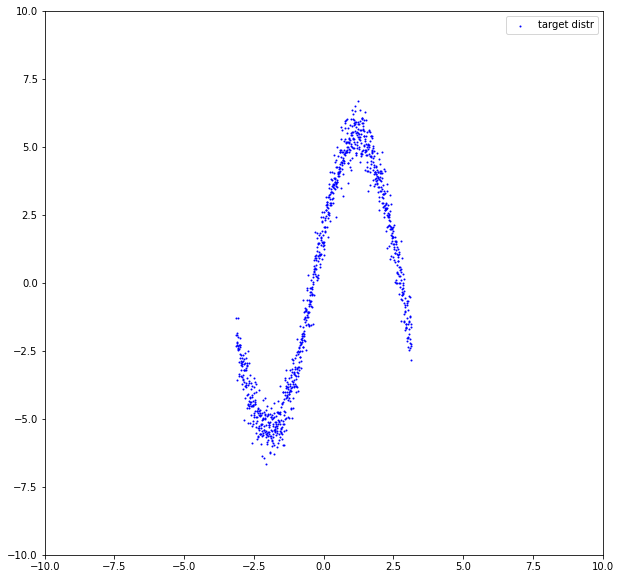

In [37]:
plt.figure(figsize=(10, 10))

plot_2d_dots(x_s, f_s, label='target distr')

plt.legend()
plt.show()

In [38]:
class RandomDataset(torch.utils.data.Dataset):
    """Our random dataset"""
    
    def __init__(self, x, y):
        self.x, self.y = x, y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return {'sample': torch.tensor(self.x[idx], dtype=torch.float), 'target': self.y[idx]}

In [39]:
our_dataset = RandomDataset(x_s, f_s)

In [40]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Linear(1, 512) # the simpliest
        # self.conv2 = nn.Linear(10, 20)
        # self.conv3 = nn.Linear(20, 10)
        self.conv4 = nn.Linear(512, 1)


    def forward(self, x):
      x = F.relu(self.conv1(x))
      # x = F.relu(self.conv2(x))
      # x = F.relu(self.conv3(x))
      x = self.conv4(x)

      return x

In [41]:
dataloader = torch.utils.data.DataLoader(our_dataset, batch_size=batch_size)

In [42]:
def DrawSampleAndLearned(x_s, f_s, pred):
  '''
  draws in 2d f_s(x_s) and pred(x_s)
  '''
  clear_output(True)
  plt.figure(figsize=(10, 10))
  plot_2d_dots(x_s, f_s, color='r', label='target distr')
  plot_2d_dots(x_s, pred, color='b', label='train distr')
  plt.legend()
  plt.show() 


In [43]:
class MseModelLosses:
  def __init__(self):
    self.mse_history = []
    self.real_risk_history = []

  def update(self, mse, real_risk):
    self.mse_history.append(mse)
    self.real_risk_history.append(real_risk)

  def draw(self):
    plt.plot(self.mse_history, color='b')
    plt.plot(self.real_risk_history, color='r')

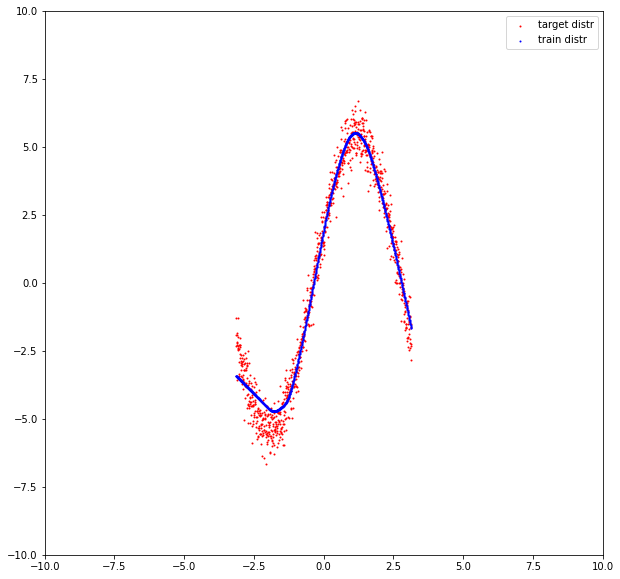

In [44]:
model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
losses = MseModelLosses()

i = 0
for epoch in range(60):
  for batch in tqdm(dataloader): # берем батч из трейн лоадера
      x_train = batch['sample']
      y_train = batch['target']

      # print(x_train.shape, y_train.shape)
      y_pred = model(x_train) # делаем предсказания
      loss = torch.nn.MSELoss()(y_pred, y_train) # считаем лосс
      loss.backward() # считаем градиенты обратным проходом
      optimizer.step() # обновляем параметры сети
      optimizer.zero_grad() # обнуляем посчитанные градиенты параметров
      i += 1


      total_pred = model(x_s)
      total_pred.detach_()

      mse = torch.nn.MSELoss()(f_s, total_pred)
      risk = torch.sum((total_pred - real_function_values)**2)

      losses.update(mse=mse, real_risk=risk)

      if i % 10 == 0:
        # plot pdfs
        DrawSampleAndLearned(x_s, f_s, total_pred)
        

In [45]:
class ModelWithWeighted(nn.Module):
    def __init__(self):
        super(ModelWithWeighted, self).__init__()
        self.conv1 = nn.Linear(1, 512) # the simpliest
        self.conv2 = nn.Linear(512, 10) # the simpliest

    def forward(self, x):
      x = F.relu(self.conv1(x))

      return self.conv2(x)

In [46]:
def CountProposedLoss(model, weights, x_s, f_s):
        # (torch.sum(model2(x_s) * F.softmax(last_layer_weights), dim=-1)).unsqueeze(1)
        
        norm_weights = F.softmax(last_layer_weights)
        y_pred_functions = model2(x_s)

        total_pred = torch.sum(y_pred_functions * norm_weights, dim=-1).unsqueeze(1)
        
        print(x_s.shape, total_pred.shape)

        
        optimizer2.zero_grad()

        weighted_mse = torch.sum(norm_weights * ((y_pred_functions - f_s)**2)) # считаем взвешенное мсе

        mse = torch.nn.MSELoss()(total_pred, f_s)

        return mse, weighted_mse, total_pred


In [47]:
class CustomModelLosses:
  def __init__(self):
    self.loss_history = []
    self.mse_history = []
    self.weighted_mse_history = []
    self.real_risk_history = []

  def update(self, loss, mse, weighted_mse, real_risk):
    self.loss_history.append(loss)
    self.mse_history.append(mse)
    self.weighted_mse_history.append(weighted_mse)
    self.real_risk_history.append(real_risk)

  def draw(self):
    plt.plot(self.loss_history, color='b')
    plt.plot(self.mse_history, color='y')
    plt.plot(self.weighted_mse_history, color='g')
    plt.plot(self.real_risk_history, color='r')

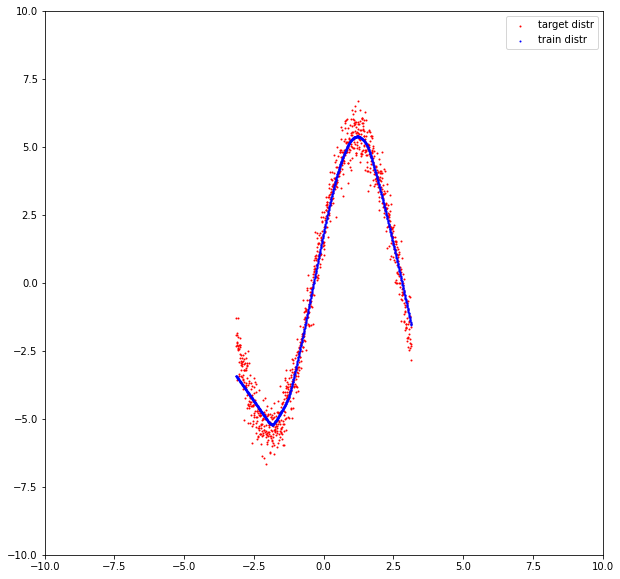

In [48]:
model2 = ModelWithWeighted()
last_layer_weights = torch.rand(10, requires_grad=True)

optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.01)
optimizer2.add_param_group({'params':last_layer_weights})

i = 0
losses2 = CustomModelLosses()

for epoch in range(60):
  for batch in tqdm(dataloader): # берем батч из трейн лоадера
      x_train = batch['sample']
      y_train = batch['target']

      mse, weighted_mse, _ = CountProposedLoss(model2, last_layer_weights, x_train, y_train)

      batch_loss = mse + weighted_mse # считаем лосс
      batch_loss.backward() # считаем градиенты обратным проходом

      optimizer2.step() # обновляем параметры сети
      optimizer2.zero_grad() # обнуляем посчитанные градиенты параметров
      i += 1

      with torch.no_grad():

        mse, weighted_mse, pred = CountProposedLoss(model2, last_layer_weights, x_s, f_s)

        DrawSampleAndLearned(x_s, f_s, pred)

        
        total_loss = mse + weighted_mse # считаем лосс

        real_risk = torch.sum((pred - real_function_values)**2)
        

        losses2.update(loss=total_loss, mse=mse, weighted_mse=weighted_mse, real_risk=real_risk)
        

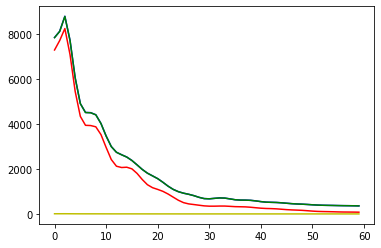

In [49]:
losses2.draw()

tensor(77.0972) tensor(133.3174)


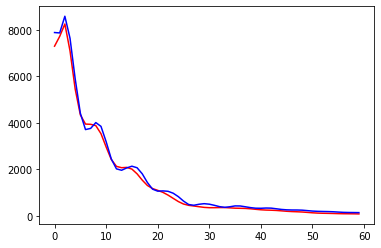

In [50]:
print(losses2.real_risk_history[-1], losses.real_risk_history[-1])

plt.plot(losses2.real_risk_history, c='r')
plt.plot(losses.real_risk_history, c='b')
plt.show()

tensor(77.0972) tensor(133.3174)


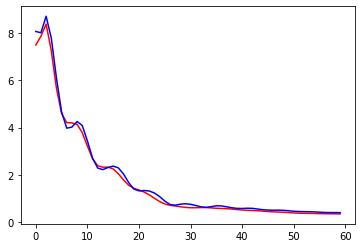

In [51]:
print(losses2.real_risk_history[-1], losses.real_risk_history[-1])
plt.plot(losses2.mse_history, c='r')
plt.plot(losses.mse_history, c='b')
plt.show()

In [52]:
print(losses2.mse_history[0], losses2.loss_history[0], losses2.weighted_mse_history[0])

tensor(7.4914) tensor(7862.7002) tensor(7855.2090)


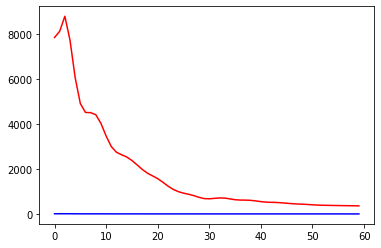

In [53]:
plt.plot(losses2.loss_history, c='r')
plt.plot(losses.mse_history, c='b')

In [54]:
new_model_pred = (torch.sum(model2(x_s) * F.softmax(last_layer_weights), dim=-1)).unsqueeze(1)
# print(new_model_pred.shape, real_function_values.shape)
print(torch.sum((new_model_pred - real_function_values)**2))
print(torch.sum((model(x_s) - real_function_values)**2))

tensor(77.0972, grad_fn=<SumBackward0>)
tensor(133.3174, grad_fn=<SumBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.
